In [1]:
import sys
sys.path.append('..')

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
import os
import pickle
import pandas
import tqdm
import numpy
import h5py

In [4]:
from matplotlib import pyplot as plt, cm
plt.rcParams['figure.figsize'] = (8, 5)

In [5]:
from persistence import load_csr_from_hdf
from linear_approx import MRkNNCoPTree
from eval import get_model_size
from visualisation import plot_with_quantiles

In [6]:
index_root = '../index'
model_root = '../models'
result_root = '../results'

In [7]:
numpy.random.seed(42)

# Load Results

In [8]:
data_to_show = []
END = '.all.pkl'
data_set_names = [fn.replace(END, '') for fn in os.listdir(result_root) if fn.endswith(END)]
for i_data_set, data_set_name in tqdm.tqdm(enumerate(data_set_names), total=len(data_set_names)): 
    # Load model dump
    with open(os.path.join(result_root, f'{data_set_name}{END}'), 'rb') as pf:
        model_dumps = pickle.load(pf)
        assert 'mrknn' in model_dumps.keys()
        
    # Evaluate
    mrknn_item = model_dumps.pop('mrknn')
    mrknn = mrknn_item['model']
    mrknn_candidate_set_size = mrknn_item['candidate_set_sizes']
    coef = mrknn.coefficients
    mrknn_size = coef.size
    for key, value in model_dumps.items():
        model = value['model']
        model_size = get_model_size(model)
        rel_model_size = model_size/mrknn_size
        
        # Candidate Set Size
        this_candidate_set_sizes = value['candidate_set_sizes']
        rel_cand_size = (this_candidate_set_sizes / numpy.maximum(mrknn_candidate_set_size, 1.0))
        mean_rel = rel_cand_size.mean()
        quartiles_rel = numpy.percentile(rel_cand_size, q=[25, 75])
        
        model_type = key[0]
        
        data_to_show.append([i_data_set, data_set_name, rel_model_size, mean_rel, quartiles_rel[0], quartiles_rel[1], 'blobs' in data_set_name, model_type])
df = pandas.DataFrame(data_to_show, columns=['dataset', 'dataset_name', 'rel_size', 'rel_cand_mean', 'rel_cand_q25', 'rel_cand_q75', 'synthetic', 'model_type'])

100%|██████████| 8/8 [00:19<00:00,  2.24s/it]


# Candidate Set Size vs. Relative Model Size

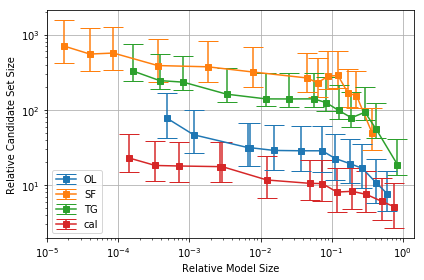

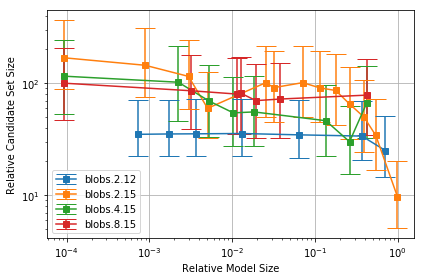

In [9]:
for syn in [False, True]:
    plt.subplots()
    selection = df.loc[df['synthetic'] == syn]
    groups = selection.groupby(by='dataset_name')
    for data_set_name, sub_df in groups:
        sub_df = sub_df.sort_values(by='rel_size')
        x = sub_df['rel_size'].values
        y = sub_df['rel_cand_mean'].values
        y_error = sub_df[['rel_cand_q25', 'rel_cand_q75']].values
        marker = 's'
        plt.errorbar(x=x, y=y, yerr=y_error.T, marker=marker, label=data_set_name, capsize=10.0)

    plt.xlabel('Relative Model Size')
    plt.ylabel('Relative Candidate Set Size')
    plt.grid()
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(f'cand_vs_model_size_{"syn" if syn else "real"}.pdf')

# Data Set Specific

In [10]:
data_set_name = 'cal'

# Load data
logging.info(f'Loading data for {data_set_name}')
with h5py.File(os.path.join(index_root, f'{data_set_name}.h5'), mode='r') as h5f:
    d = load_csr_from_hdf(h5f=h5f, key='distances')
kd = d.data.reshape([d.shape[0], -1])
skd = numpy.sort(kd, axis=-1)

with open(os.path.join(index_root, f'{data_set_name}.index'), 'rb') as pf:
    index = pickle.load(pf)
x = index.get_arrays()[0]

with open(os.path.join(model_root, f'{data_set_name}.mrknn'), 'rb') as pf:
    mrknn = pickle.load(pf)

# Load model dump
with open(os.path.join(result_root, f'{data_set_name}.all.pkl'), 'rb') as pf:
    model_dumps = pickle.load(pf)
    assert 'mrknn' in model_dumps.keys()

mrknn_item = model_dumps.pop('mrknn')
mrknn = mrknn_item['model']
mrknn_candidate_set_size = mrknn_item['candidate_set_sizes']
coef = mrknn.coefficients
mrknn_size = coef.size

INFO:root:Loading data for cal


## Relative Candidate Set Size vs k vs Model Size

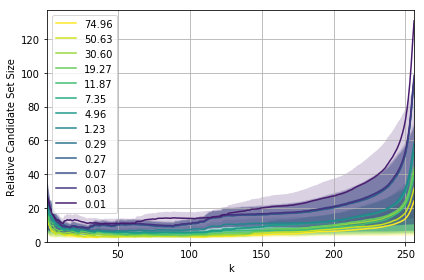

In [11]:
data_to_show = []
relative = True

# Evaluate
sorted_values = []
labels = []
c_values = [1]
for key, value in model_dumps.items():
    model = value['model']
    model_size = get_model_size(model)
    rel_model_size = model_size/mrknn_size
    # Candidate Set Size
    this_candidate_set_size = value['candidate_set_sizes']
    if relative:
        this_candidate_set_size = this_candidate_set_size / numpy.maximum(mrknn_candidate_set_size, 1.0)
    sorted_values.append(this_candidate_set_size)
    c_values.append(rel_model_size)
    labels.append(f'{100*rel_model_size:2.2f}')

cmap = cm.get_cmap()
arg_sort = numpy.asarray(sorted(range(len(c_values)), key=lambda i: c_values[i]), dtype=numpy.float64)
arg_sort /= arg_sort.max()
colors = cmap(arg_sort)
plot_with_quantiles(*sorted_values, ci=0.5, alpha=0.2, colors=colors)
plt.legend(labels)
plt.grid()
plt.xlabel('k')
plt.ylabel('Relative Candidate Set Size')
plt.tight_layout()
plt.savefig(f'{data_set_name}_cand_wrt_k.pdf')

# Concrete Example Prediction

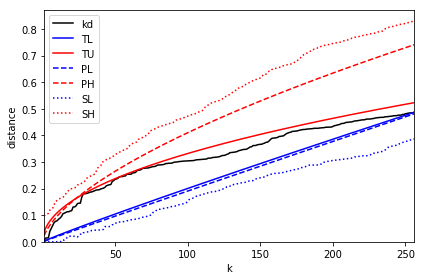

In [12]:
first = model_dumps[('decision_tree_regressor', (('max_depth', 21), ('min_samples_leaf', 2)))]
first_model = first['model']
pred_coef = first_model.predict(x)
pred_mrknn = MRkNNCoPTree()
pred_mrknn.coefficients = pred_coef.reshape((-1, 2, 2))

mrknn_lower, mrknn_upper = mrknn.predict_bounds()
mrknn_pred_lower, mrknn_pred_upper = pred_mrknn.predict_bounds()

mrknn_pred_lower_error = numpy.maximum(mrknn_pred_lower - skd, 0).max(axis=0)
mrknn_pred_upper_error = numpy.maximum(skd - mrknn_pred_upper, 0).max(axis=0)

i = numpy.random.randint(x.shape[0])

ks = numpy.arange(1, mrknn_lower.shape[1]+1)
plt.plot(ks, skd[i, :], c='black', label='kd')
plt.plot(ks, mrknn_lower[i, :], c='blue', label='TL')
plt.plot(ks, mrknn_upper[i, :], c='red', label='TU')
plt.plot(ks, mrknn_pred_lower[i, :], c='blue', ls='--', label='PL')
plt.plot(ks, mrknn_pred_upper[i, :], c='red', ls='--', label='PH')
plt.plot(ks, numpy.maximum(mrknn_pred_lower[i, :] - mrknn_pred_lower_error, 0.0), c='blue', ls=':', label='SL')
plt.plot(ks, mrknn_pred_upper[i, :] + mrknn_pred_upper_error, c='red', ls=':', label='SH')
plt.xlim(1, 256)
ylim = list(plt.ylim())
ylim[0] = 0
plt.ylim(ylim)
plt.xlabel('k')
plt.ylabel('distance')
plt.legend()
plt.tight_layout()
plt.savefig('example.pdf')

# Error Distribution

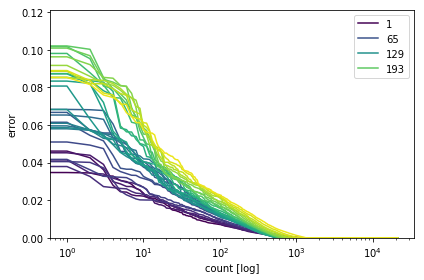

In [13]:
first = model_dumps[('decision_tree_regressor', (('max_depth', 21), ('min_samples_leaf', 2)))]

first_model = first['model']
pred_coef = first_model.predict(x)
pred_mrknn = MRkNNCoPTree()
pred_mrknn.coefficients = pred_coef.reshape((-1, 2, 2))

mrknn_lower, mrknn_upper = mrknn.predict_bounds()
mrknn_pred_lower, mrknn_pred_upper = pred_mrknn.predict_bounds()

mrknn_pred_lower_error = numpy.maximum(mrknn_pred_lower - skd, 0)
mrknn_pred_upper_error = numpy.maximum(skd - mrknn_pred_upper, 0)

cmap = cm.get_cmap()
k_max = mrknn_pred_upper_error.shape[1]
    
plt.subplots()
for k in range(0, k_max, 8):
    if k % 64 == 0:
        label = str(k+1)
    else:
        label = None
    plt.plot(numpy.sort(mrknn_pred_upper_error[:, k])[::-1], ls='-', c=cmap(k/256), label=label)
plt.xscale('log')
ylim = list(plt.ylim())
ylim[0] = 0
plt.ylim(ylim)
plt.xlabel('count [log]')
plt.ylabel('error')
plt.legend()
plt.tight_layout()
plt.savefig('err_distribution_upper.pdf')
